In [198]:
using Optim
using Plots
using Statistics

In [2]:
function interpolate1D(vX, vY, x)
    imin = sum(vX.<x);
    imax = sum(vX.<x)+1;
    y = vY[imin]+( x-vX[imin] )/( vX[imax]-vX[imin] )*(vY[imax]-vY[imin]);
    return y
end

interpolate1D (generic function with 1 method)

In [3]:
# Value function
function valfun(v0, pBeta, pDelta, pAlpha, vK, k0, s, k)

    # This program gets the value function for a neoclassical growth model with
    # no uncertainty and CRRA utility
    
    g = interpolate1D(vK,v0,k); # smooths out previous value function
    
    c = k0^pAlpha-k + (1-pDelta)*k0; # consumption
    if c <= 0
        val =-888888888888888888-800*abs(c); # keeps it from going negative
    else
        val=(1/(1-s))*(c^(1-s)-1) + pBeta*g;
    end
    val =-val; # make it negative since we're maximizing and code is to minimize.
    
    return val
                
end

valfun (generic function with 1 method)

In [71]:
# Deterministic Growth model
# Tarik OCAKTAN - Luxembourg - November 2020

# State space dimension = 1

# Notation:
#  pName : structural parameters
#  iName : total number of variables related to the algorithm
#  idxName : indexation used in loops, i.e. idxName = 1,...,iName
#  dName : integer of a specific value of a variable, i.e. dNamess=steady state
#          of
#               variable 'Name'
#  vName : vector containing values of variable 'Name'
#  mName : matrix containing values of a variable 'Name'



# Structural parameters
pAlpha  =  .33;
pBeta   =  .95;
pDelta  = 0.1;
s       = 2;

# Algorithm parameters
 iIter = 1000; # maximum number of iterations
 iGridPoints = 6000;
 iToler	= 0.00001;  # convergence criterion

# Steady state value
 dKss = (pAlpha/(1/pBeta-(1-pDelta)))^(1/(1-pAlpha));
 dCss = dKss^(pAlpha)-pDelta*dKss;
 dIss = pDelta*dKss;
 dYss = dKss^pAlpha;

# Bounds of state space
 dKmin = dKss * 0.25;
 dKmax = dKss * 1.75;



In [72]:
# Construct a grid
 iStep = (dKmax-dKmin) / (iGridPoints-1);
 vK = collect(dKmin:iStep:dKmax);
 iGridPoints = size(vK,1); # overwriting iGridPoints in order to take into
                           # account additional point

# Storage space
 polfun = zeros(iGridPoints);
 v0 = zeros(iGridPoints);
 v1 = collect( zeros(iGridPoints) );
 k11 = collect( zeros(iGridPoints) );

 con = zeros(iGridPoints);
 

 iDif = 10;
 idxIter = 0;

In [225]:
### Choice of optimization method
# 1: julia optimizer
# 2: Simulated Annealing
iOptimizationMethod = 1

while iDif>iToler && idxIter<iIter;
#for idxIter=1:100
   for i=1:iGridPoints

      k0 = vK[i];
      
        
      if ( iOptimizationMethod == 1 )
          # Smoothing the value function: Optimisation step (julia optimizer)
          opt = optimize( k -> valfun(v0, pBeta, pDelta, pAlpha, vK, k0, s, k),
                               dKmin, dKmax, GoldenSection());  
          k1 = Optim.minimizer(opt);   
          # End : julia optimizer  
      elseif ( iOptimizationMethod == 2 )
          # Smoothing the value function: Optimisation step (Monte Carlo method: Simuated Annealing) 
          # The Monte Carlo maximum
          nsim = 5;
          u = rand(nsim)
          # Simulated annealing
          xval = collect(zeros(nsim));
          r = .5
          for i = 2:nsim
            # U[a,b]
            a = max(xval[i-1]-r,0);
            b = min(xval[i-1]+r,1);
            test = rand() * ( (b-a) + a );
            delta = valfun(test) .- valfun(xval[i-1]);
            rho = min.( exp.(delta*log(i)/1),1 );
            xval[i] = test .* ( u[i] .< rho ) .+ xval[i-1]*( u[i] .> rho );
          end
          k1 = xval[nsim];  
          # End : Simulated Annealing  
       else
          print("Wrong choice of optimization algorithm ...")
       end     
        
        
      v1[i] = -valfun(v0, pBeta, pDelta, pAlpha, vK, k0, s, k1);
      k11[i] = k1;           
        
   end;
    
   iDif = sqrt( sum( v1-v0 ) );
   v0 = v1;
  
 
    
   idxIter = idxIter+1;
#end     
    
end

print(v1[iGridPoints])

3.981623652967724

In [217]:
for i = 1:iGridPoints
    con[i] = vK[i]^(pAlpha)-k11[i] + (1-pDelta)*vK[i];
    polfun[i] = vK[i]^(pAlpha)-k11[i] + (1-pDelta)*vK[i];
    end 

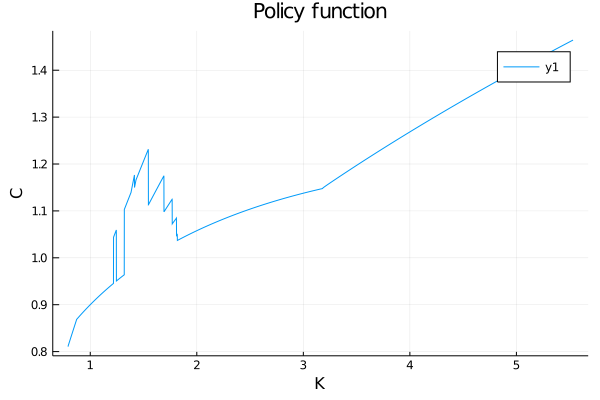

In [218]:
plot(vK,con, title="Policy function")
xlabel!("K")
ylabel!("C")


In [204]:


# The function to be optimized
function mci(x)
    y = ( cos.(50*x ) + sin.( 20 *x ) ).^2;
    return y
end
    
# The Monte Carlo maximum
nsim = 5000;
u = rand(nsim)


# Simulated annealing
xval = collect(zeros(nsim));
r = .5

for i = 2:nsim
    # U[a,b]
    a = max(xval[i-1]-r,0);
    b = min(xval[i-1]+r,1);
    test = rand() * ( (b-a) + a );
    delta = mci(test) .- mci(xval[i-1]);
    rho = min.( exp.(delta*log(i)/1),1 );
    xval[i] = test .* ( u[i] .< rho ) .+ xval[i-1]*( u[i] .> rho );
end
mci(xval[nsim])

# Plot the trajectory of the optimization path
plot(xval,mci(xval), title="Monte Carlo Optimization: Simulated Annealing")
xlabel!("x")
ylabel!("f(x)")

print("The maximum is given by:")
print("\n")
print( mean( xval[4970:5000] ) )
print("\n")
print("and")
print("\n")
print( mean( mci(xval[4970:5000]) ) )

#plot(function(x)mci(x), xlim=c(0,1),ylim=c(0,4),xlab="Function",ylab="")
#plot(xval,mci(xval),type="l",lwd=2)

The maximum is given by:
0.541753776962503
and
3.7586703157626116

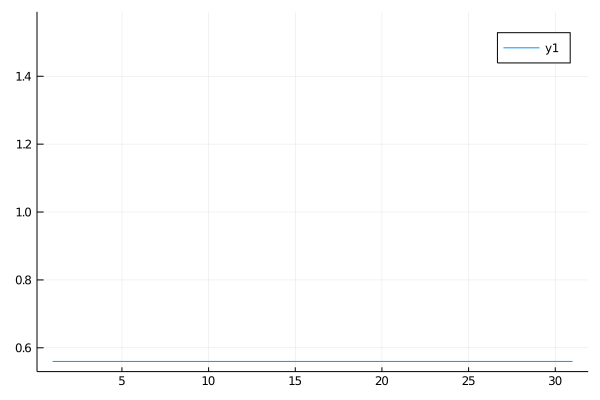

In [206]:
plot(xval[4970:5000])